# Intuit Quickbooks Upgrade

* Team-lead GitLab userid:
* Group name:
* Team member names:

## Setup

Please complete this python notebook with your group by answering the questions in `intuit.pdf`. Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML file from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the first group assignment for MGTA 455 and you will be using Git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's change to accept so the team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `question1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - question1.ipynb, question2.ipynb, question3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/git-group-workflow-wbg.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/zJHwodmjatY
* Dealing with Merge Conflicts: https://youtu.be/qFnyb8_rgTI
* Group assignment practice: https://youtu.be/4Ty_94gIWeA

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [3]:
# Seeing the data
import qgrid

qgrid.show_grid(intuit75k.loc[:, :])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# checking datatypes
intuit75k.dtypes

id               int32
zip             object
zip_bins         int32
sex           category
bizflag          int32
numords          int32
dollars        float64
last             int32
sincepurch       int32
version1         int32
owntaxprod       int32
upgraded         int32
res1          category
training         int32
res1_yes         int64
dtype: object

In [5]:
# Converting 1/0 variables to categorical
intuit75k["zip_bins"] = pd.Categorical(intuit75k["zip_bins"])
intuit75k["id"] = pd.Categorical(intuit75k["id"])

In [6]:
# Checking correlations
intuit75k.corr()

,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,training,res1_yes
bizflag,1.000000,0.000197,0.002038,-0.000390,-0.005220,-0.006011,0.004565,-0.003080,-0.003159,0.000793
numords,0.000197,1.000000,0.585654,-0.130356,0.001763,0.005728,0.119726,-0.002755,-0.006790,0.093512
dollars,0.002038,0.585654,1.000000,-0.074659,0.000815,0.002217,0.074988,-0.001420,-0.007628,0.067876
last,-0.000390,-0.130356,-0.074659,1.000000,-0.001169,0.002018,-0.019854,-0.000192,0.002887,-0.089597
sincepurch,-0.005220,0.001763,0.000815,-0.001169,1.000000,0.524144,-0.001149,0.511277,-0.006168,0.078900
version1,-0.006011,0.005728,0.002217,0.002018,0.524144,1.000000,-0.084814,-0.267716,-0.003192,0.043701
owntaxprod,0.004565,0.119726,0.074988,-0.019854,-0.001149,-0.084814,1.000000,0.087418,-0.000593,0.029017
upgraded,-0.003080,-0.002755,-0.001420,-0.000192,0.511277,-0.267716,0.087418,1.000000,-0.004535,0.066733
training,-0.003159,-0.006790,-0.007628,0.002887,-0.006168,-0.003192,-0.000593,-0.004535,1.000000,-0.003089
res1_yes,0.000793,0.093512,0.067876,-0.089597,0.078900,0.043701,0.029017,0.066733,-0.003089,1.000000


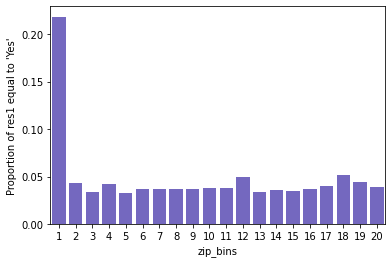

In [7]:
# proportion of people who responded positively across every zip code bin
fig = rsm.prop_plot(intuit75k, "zip_bins", "res1", "Yes")

In [8]:
intuit75k['responsive_bin'] = np.where(intuit75k['zip_bins'] == 1, 'Res_ZIP_bin', 'NRes_ZIP_bin')

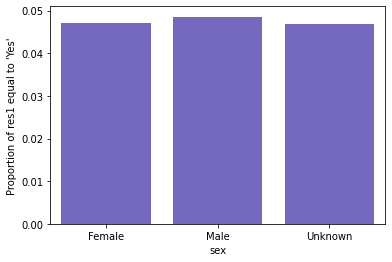

In [9]:
# proportion of people who responded positively across every sex
fig = rsm.prop_plot(intuit75k, "sex", "res1", "Yes")

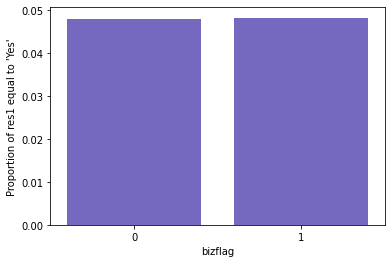

In [10]:
# proportion of people who responded positively across bizflag
fig = rsm.prop_plot(intuit75k, "bizflag", "res1", "Yes")

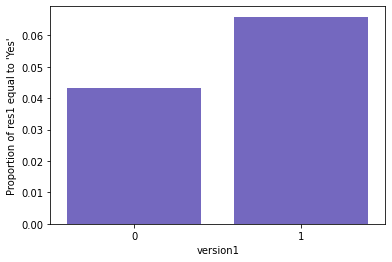

In [11]:
# proportion of people who responded positively across version1
fig = rsm.prop_plot(intuit75k, "version1", "res1", "Yes")

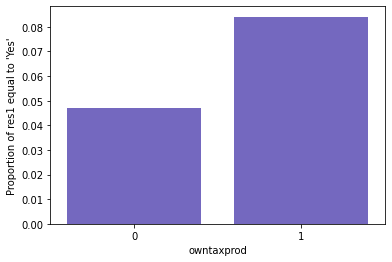

In [12]:
# proportion of people who responded positively across owntaxprod
fig = rsm.prop_plot(intuit75k, "owntaxprod", "res1", "Yes")

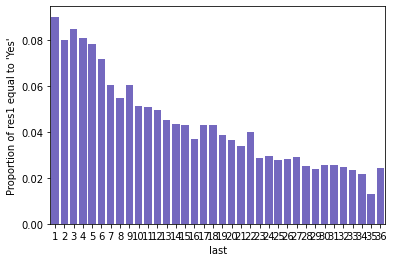

In [13]:
# proportion of people who responded positively across upgraded
fig = rsm.prop_plot(intuit75k, "last", "res1", "Yes")

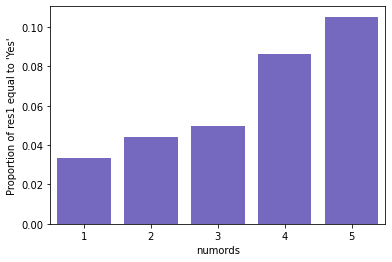

In [14]:
fig = rsm.prop_plot(intuit75k, "numords", "res1", "Yes")

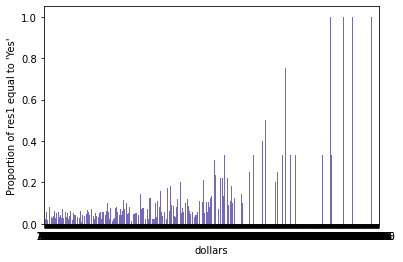

In [15]:
fig = rsm.prop_plot(intuit75k, "dollars", "res1", "Yes")

In [16]:
def make_version_status(x, y):
    if x == 1 and y == 0:
        return "BoughtV1_CurrentV1"
    if x == 0 and y == 1:
        return "BoughtV1_CurrentV2"
    if x == 0 and y == 0:
        return "BoughtV2_CurrentV2"


intuit75k["version_status"] = intuit75k[["version1", "upgraded"]].apply(
    lambda x: make_version_status(*x), axis=1
)

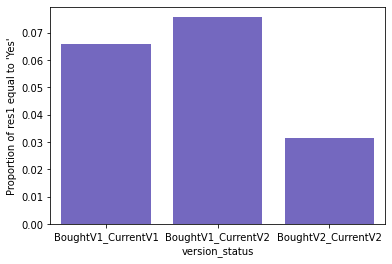

In [17]:
fig = rsm.prop_plot(intuit75k, "version_status", "res1", "Yes")

In [18]:
intuit75k = intuit75k.assign(rec_iq=rsm.xtile(intuit75k["last"], 5))
intuit75k = intuit75k.assign(freq_iq=rsm.xtile(intuit75k["numords"], 5, rev=True))
intuit75k = intuit75k.assign(mon_iq=rsm.xtile(intuit75k["dollars"], 5, True))
intuit75k = intuit75k.assign(
    rfm_iq=intuit75k["rec_iq"].astype(str)
    + intuit75k["freq_iq"].astype(str)
    + intuit75k["mon_iq"].astype(str)
)

In [19]:
#RFM Sequential Bins
intuit75k = intuit75k.assign(freq_sq=intuit75k.groupby("rec_iq")["numords"].transform(rsm.xtile, 5, rev=True))
intuit75k = intuit75k.assign(mon_sq=intuit75k.groupby(["rec_iq", "freq_sq"])["dollars"].transform(rsm.xtile, 5, rev=True))
intuit75k = intuit75k.assign(
    rfm_sq=intuit75k["rec_iq"].astype(str)
    + intuit75k["freq_sq"].astype(str)
    + intuit75k["mon_sq"].astype(str)
)

<br>
<br>
<br>

In [20]:
pd.set_option('display.max_columns', None)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes,responsive_bin,version_status,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,3,2,132,4,2,142
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,5,3,153,5,2,152
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0,NRes_ZIP_bin,BoughtV1_CurrentV2,3,1,2,312,1,5,315
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0,Res_ZIP_bin,BoughtV2_CurrentV2,3,5,5,355,5,4,354
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,5,5,155,5,4,154


In [21]:
intuit75k_copy = intuit75k.copy(deep = True)

In [22]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
sf = scaler.fit(intuit75k[['numords','dollars','last','sincepurch']])
intuit75k_copy[['numords','dollars','last','sincepurch']] = sf.transform(intuit75k_copy[['numords','dollars','last','sincepurch']])

In [23]:
intuit75k_copy.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes,responsive_bin,version_status,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq
0,1,94553,18,Male,0,-0.061449,0.202116,-1.136223,-0.364760,0,0,0,No,1,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,3,2,132,4,2,142
1,2,53190,10,Unknown,0,-0.867026,-0.290463,-1.241056,-1.262404,0,0,0,No,0,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,5,3,153,5,2,152
2,3,37091,8,Male,0,1.549704,-0.001073,-0.192728,1.330790,0,0,1,No,0,0,NRes_ZIP_bin,BoughtV1_CurrentV2,3,1,2,312,1,5,315
3,4,02125,1,Male,0,-0.867026,-0.875400,0.121771,-1.461881,0,0,0,No,1,0,Res_ZIP_bin,BoughtV2_CurrentV2,3,5,5,355,5,4,354
4,5,60201,11,Male,0,-0.867026,-0.844613,-1.450722,-1.262404,0,0,0,No,0,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,5,5,155,5,4,154


In [24]:
cost= 1.41
margin= 60
breakeven_rr= cost/margin

In [25]:
# Logistic regression via statsmodel (using the formula API)
lr_mod = smf.glm(
    formula="res1_yes ~ responsive_bin + numords + dollars + last +  owntaxprod + version_status",
    family=Binomial(link=logit()),
    data=intuit75k_copy[intuit75k_copy.training == 1]
)
lr = lr_mod.fit()

########################################################################################
lr_mod1 = smf.glm(
    formula="res1_yes ~ responsive_bin + numords + dollars + last +  owntaxprod + upgraded*sincepurch",
    family=Binomial(link=logit()),
    data=intuit75k_copy[intuit75k_copy.training == 1]
)
lr1 = lr_mod1.fit()

#########################################################################################
lr_mod2 = smf.glm(
    formula="res1_yes ~ zip_bins +  numords + dollars + last +  owntaxprod + upgraded:sincepurch  + version_status",
    family=Binomial(link=logit()),
    data=intuit75k_copy[intuit75k_copy.training == 1]
)
lr2 = lr_mod2.fit()

###########################################################################################
lr_mod3 = smf.glm(
    formula="res1_yes ~ responsive_bin + rfm_iq +  owntaxprod + version_status",
    family=Binomial(link=logit()),
    data=intuit75k_copy[intuit75k_copy.training == 1]
)
lr3 = lr_mod3.fit()


In [26]:
rsm.vif(lr_mod)

,variable,vif,Rsq
0,version_status[T.BoughtV1_CurrentV2],1.583,0.368
1,version_status[T.BoughtV2_CurrentV2],1.570,0.363
2,numords,1.558,0.358
3,dollars,1.527,0.345
4,owntaxprod,1.027,0.026
5,last,1.017,0.017
6,responsive_bin[T.Res_ZIP_bin],1.000,0.000


In [27]:
lr.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,5134.373,0.000,1
responsive_bin,1357.593,0.000,1
version_status,436.235,0.000,2
numords,145.441,0.000,1
dollars,15.926,0.000,1
last,327.220,0.000,1
owntaxprod,8.717,0.003,1


In [28]:
# making chnages to push
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               res1_yes   No. Observations:                52500
Model:                            GLM   Df Residuals:                    52492
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8915.4
Date:                Wed, 10 Feb 2021   Deviance:                       17831.
Time:                        06:10:00   Pearson chi2:                 5.14e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -3.0649      0.043    -71.655      0.000      -3.149      -2.981
responsive_bin[T.Res_ZIP_bin]            2.0226      0.055     36.846      0.000       1.915       2.130
version_status[T.BoughtV1_CurrentV2]     0.2157      0.056      3.880      0.000       0.107       0.325
version_status[T.BoughtV2_CurrentV2]    -0.7784      0.053    -14.785      0.000      -0.882      -0.675
numords                                  0.2855      0.024     12.060      0.000       0.239       0.332
dollars                                  0.0883      0.022      3.991      0.000       0.045       0.132
last                                    -0.4175      0.023    -18.089      0.000      -0.463      -0.372
owntaxprod                               0.3034      0.103      2.952      0.003       0.102       0.505
========================================================================================================
"""

In [29]:
rsm.or_ci(lr)

,index,OR,OR%,2.5%,97.5%
1,responsive_bin[T.Res_ZIP_bin],7.558,655.759%,6.787,8.416
2,version_status[T.BoughtV1_CurrentV2],1.241,24.074%,1.113,1.384
3,version_status[T.BoughtV2_CurrentV2],0.459,-54.086%,0.414,0.509
4,numords,1.330,33.045%,1.270,1.394
5,dollars,1.092,9.235%,1.046,1.141
6,last,0.659,-34.129%,0.630,0.689
7,owntaxprod,1.354,35.448%,1.107,1.657


In [30]:
rsm.model_fit(lr)


Pseudo R-squared (LR): 0.112
Pseudo R-squared (McFadden): 0.112
Log-likelihood: -8915.405, AIC: 17846.81, BIC: 17917.759
Chi-squared: 51395.168 df(7), p.value < 0.001 
Nr obs: 52,500



<AxesSubplot:xlabel='Odds-ratio'>

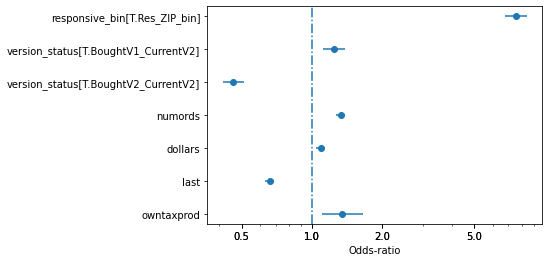

In [31]:
rsm.or_plot(lr)

In [32]:
def add_predict_col(df_pred,df2_concat, lr, colsuffix, breakeven):
    predicted = lr.predict(df_pred)/2
    df2_concat['predicted_'+colsuffix] = predicted
    df2_concat['predicted_yes_'+colsuffix] = np.where(df2_concat['predicted_'+colsuffix] > breakeven, 1, 0)
    return df2_concat

In [37]:
def create_cm_roc_profit(df, pred_col, pred_col_prob):
    confusion_matrix = pd.crosstab(df[df.training == 0]['res1_yes'], df[df.training == 0][pred_col])
    
    accuracy = (confusion_matrix[1][1] + confusion_matrix[0][0])/confusion_matrix.values.sum()
    f1 = 2*confusion_matrix[1][1]/(2*confusion_matrix[1][1] + confusion_matrix[1][0] + confusion_matrix[0][1])
    roc_score = roc_auc_score(df[df.training == 0]['res1_yes'], df[df.training == 0][pred_col])
    
    profit = rsm.profit_max(df[df.training == 0], 'res1_yes',1 ,pred_col_prob,1.41,60)
    
    print("Accuracy is {}".format(accuracy))
    print("F1 Score is {}".format(f1))
    print("ROC AUC is {}".format(roc_score))
    print("Profit is {}".format(profit))
    return roc_score,profit,confusion_matrix
    

In [38]:
intuit75k = add_predict_col(intuit75k_copy, intuit75k, lr, 'lr', breakeven_rr)
intuit75k = add_predict_col(intuit75k_copy, intuit75k, lr1, 'lr1', breakeven_rr)
intuit75k = add_predict_col(intuit75k_copy, intuit75k, lr2, 'lr2', breakeven_rr)
intuit75k = add_predict_col(intuit75k_copy, intuit75k, lr3, 'lr3', breakeven_rr)

In [39]:
roc_lr, profit_lr, cm_lr = create_cm_roc_profit(intuit75k, 'predicted_yes_lr', 'predicted_lr')
cm_lr

Accuracy is 0.7064888888888889
F1 Score is 0.1858974358974359
ROC AUC is 0.6956297539783561
Profit is 35357.31


predicted_yes_lr,0,1
res1_yes,,
0,15142,6255
1,349,754


In [40]:
roc_lr1, profit_lr1, cm_lr1 = create_cm_roc_profit(intuit75k, 'predicted_yes_lr1', 'predicted_lr1')
cm_lr1

Accuracy is 0.7081333333333333
F1 Score is 0.18614450365596727
ROC AUC is 0.6952045369812521
Profit is 35237.94


predicted_yes_lr1,0,1
res1_yes,,
0,15182,6215
1,352,751


In [41]:
roc_lr2, profit_lr2, cm_lr2 = create_cm_roc_profit(intuit75k, 'predicted_yes_lr2', 'predicted_lr2')
cm_lr2

Accuracy is 0.7095111111111111
F1 Score is 0.18584952665670154
ROC AUC is 0.6937792306231151
Profit is 34995.75


predicted_yes_lr2,0,1
res1_yes,,
0,15218,6179
1,357,746


In [42]:
roc_lr3, profit_lr3, cm_lr3 = create_cm_roc_profit(intuit75k, 'predicted_yes_lr3', 'predicted_lr3')
cm_lr3

Accuracy is 0.7168444444444444
F1 Score is 0.18809736204919078
ROC AUC is 0.6941953801659437
Profit is 34770.96


predicted_yes_lr3,0,1
res1_yes,,
0,15391,6006
1,365,738


In [43]:
peformance_df = pd.DataFrame({'model':['lr','lr1','lr2','lr3'],'profit':[profit_lr,profit_lr1,profit_lr2,profit_lr3],'ROC_AUC_Score':[roc_lr,roc_lr1,roc_lr2,roc_lr3]})
peformance_df

,model,profit,ROC_AUC_Score
0,lr,35357.31,0.695630
1,lr1,35237.94,0.695205
2,lr2,34995.75,0.693779
3,lr3,34770.96,0.694195


<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

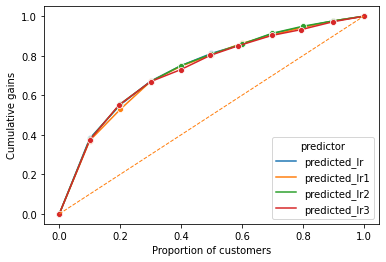

In [48]:
rsm.gains_plot(intuit75k[intuit75k.training == 0], 'res1_yes', 1, pred = ['predicted_lr','predicted_lr1','predicted_lr2','predicted_lr3'])


<AxesSubplot:xlabel='Proportion of customers', ylabel='Profit'>

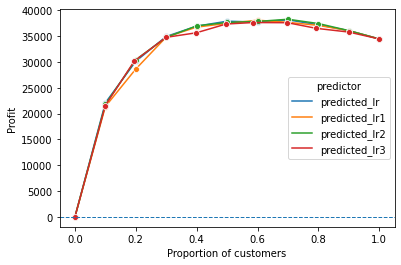

In [49]:
rsm.profit_plot(df=intuit75k[intuit75k.training == 0],rvar='res1_yes',lev=1,pred=['predicted_lr','predicted_lr1','predicted_lr2','predicted_lr3'],cost=1.41,margin=60)


<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative lift'>

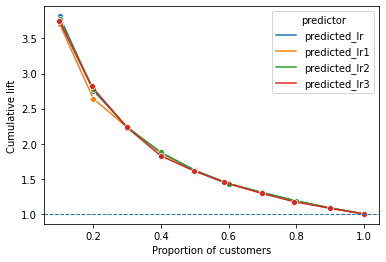

In [50]:
rsm.lift_plot(df=intuit75k[intuit75k.training == 0],rvar='res1_yes',lev=1,pred=['predicted_lr','predicted_lr1','predicted_lr2','predicted_lr3'])


<AxesSubplot:xlabel='Proportion of customers', ylabel='Return on Marketing Expenditures (ROME)'>

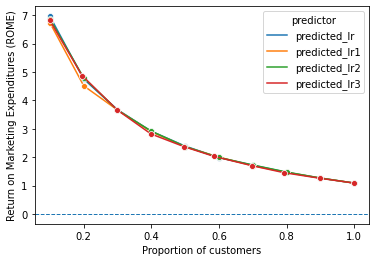

In [51]:
rsm.ROME_plot(df=intuit75k[intuit75k.training == 0],rvar='res1_yes',lev=1,pred=['predicted_lr','predicted_lr1','predicted_lr2','predicted_lr3'], cost=1.41,margin=60)


In [52]:
prop_reached = sum(intuit75k[intuit75k.training == 0]['predicted_yes_lr'])/len(intuit75k[intuit75k.training == 0])
prop_reached

0.3115111111111111

In [53]:
response_rate = np.mean(intuit75k[(intuit75k.predicted_yes_lr == 1) & (intuit75k.training == 0)]['res1_yes'])
response_rate

0.10757597374803823

In [54]:
total_biz = 801821
already_resp = 38487
population = total_biz - already_resp
targets = population * prop_reached
responses = targets * response_rate

In [55]:
cost = targets * 1.41
rev = responses * 60
profit = rev - cost
profit

1199530.527624

In [56]:
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes,responsive_bin,version_status,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq,predicted_lr,predicted_yes_lr,predicted_lr1,predicted_yes_lr1,predicted_lr2,predicted_yes_lr2,predicted_lr3,predicted_yes_lr3
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,3,2,132,4,2,142,0.016644,0,0.020002,0,0.022737,0,0.018766,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,5,3,153,5,2,152,0.013319,0,0.011987,0,0.012232,0,0.024261,1
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0,NRes_ZIP_bin,BoughtV1_CurrentV2,3,1,2,312,1,5,315,0.044481,1,0.044718,1,0.044049,1,0.059333,1
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0,Res_ZIP_bin,BoughtV2_CurrentV2,3,5,5,355,5,4,354,0.050033,1,0.042564,1,0.049989,1,0.050980,1
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0,NRes_ZIP_bin,BoughtV2_CurrentV2,1,5,5,155,5,4,154,0.013828,0,0.012453,0,0.013415,0,0.012855,0


In [58]:
df_logit = intuit75k[['id','predicted_lr1']]
df_logit.rename(columns = {'predicted_lr1':'prediction_logit'}, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [59]:
df_logit

,id,prediction_logit
0,1,0.020002
1,2,0.011987
2,3,0.044718
3,4,0.042564
4,5,0.012453
...,...,...
74995,74996,0.037629
74996,74997,0.008126
74997,74998,0.019767
74998,74999,0.017790
